# Simulating coupled Classical Harmonic oscillators using Classiq



## Theoretical Background:
___

We are trying to find a solution for a system of classical coupled harmonic oscillators with $N=2^n$ masses. Let $\vec{x}$ be the displacement vector
$$
    \vec{x} = \left(x_1(t),.....,x_N(t) \right)^T \in \mathbb{R}^N
    \qquad (1)
$$
So, for the system of $N$ masses connected by springs, Newton's equation becomes
$$
    m_j \ddot{x}_j(t) = \sum_{k \neq j} \kappa_{jk} \left( x_k(t) - x_j(t) \right) - \kappa_{jj} x_j(t) \qquad (2)
$$
where $j \in [N] := \{1,...,N\}$ and $\kappa_{jk}$ is the spring constant of the spring connecting the $j ^{th}$ and the $k ^{th}$ masses.

Representing Newton's Equation in matrix form:
$$
    \mathbf{M}\ddot{\vec{x}}(t) = - \mathbf{F}\vec{x}(t)
    \qquad (3)
$$
where $\mathbf{M}$ is the $N\times N$ diagonal matrix with entries $m_j > 0$ and $\mathbf{F}$ is an $N\times N$ matrix with $f_{jj}=\sum_k \kappa_{jk}$ and $f_{jk} = -\kappa_{jk}$.

___



In order to reduce Newton's Equation to a Quantum Evolution, we perform a change of variable where $\vec{y}(t) := \sqrt{\mathbf{M}}\vec{x}(t)$. Equation $(3)$ becomes:
$$
    \ddot{\vec{y}}(t) = -\mathbf{A}\vec{y}(t)
    \qquad (4)
$$
where $\mathbf{A} := \sqrt{\mathbf{M}}^{-1}\mathbf{F}\sqrt{\mathbf{M}}^{-1}$. Convert equation (4) into a similar form of Schrödinger's Equation by adding $i\sqrt{\mathbf{A}}\dot{\vec{y}}(t)$ on both sides of equation $4$,
$$
    \ddot{\vec{y}}(t) + i\sqrt{\mathbf{A}}\dot{\vec{y}}(t)=i\sqrt{\mathbf{A}}\left(\dot{\vec{y}}(t) + i\sqrt{\mathbf{A}}\vec{y}(t)\right)
    \qquad (5)
$$
Solution to (5) is
$$
    \dot{\vec{y}}(t) + i\sqrt{\mathbf{A}}\vec{y}(t) = e^{it\sqrt{\mathbf{A}}}\left(\dot{\vec{y}}(0) + i\sqrt{\mathbf{A}}\vec{y}(0)\right)
    \qquad (6)
$$

___

In order to access $\sqrt{\mathbf{A}}$, define $\mathbf{B}\mathbf{B^\dagger} = \mathbf{A}$ where B is $N\times M$ and $M = N\times (N+1) /2$. However, to simulate the Hamiltonian using qubits, we need it to be a square matrix of dimension $2^{q}$ where $q$ is the number of qubits simulating $H$. To achieve this, we  pad $B$ with zeros to make its dimension $N^2\times N^2$, so that $H$ becomes a $2N^{2}X2N^{2}$ matrix which can be simulated with $q=2n+1$ qubits, where $N=2^{n}$. So, the hamiltonian after padding becomes
$$
    \mathbf{H} := -\begin{pmatrix}
\mathbf{0}{_{N^{2}XN^{2}}} & \mathbf{B}{_{N^{2}XN^{2}}}\\
\mathbf{B^\dagger}{_{N^{2}XN^{2}}} & \mathbf{0}{_{N^{2}XN^{2}}}
\end{pmatrix}_{2N^{2}X2N^{2}}
\qquad (7)
$$
(5) can be stated as:
$$
    |{\dot{\psi}(t)}\rangle = -i\mathbf{H} |{\psi(t)}\rangle
    \qquad (8)
$$
where
$$
    |{\psi(t)}\rangle \propto \begin{pmatrix}
\dot{\vec{y}}(t)\\
i\mathbf{B^\dagger}\vec{y}(t)
\end{pmatrix}
\qquad (9)
$$
is an appropriate solution to equation $(8)$

Here $\mathbf{A}$ is positive-semi definite and Hermitian by definition, Cholesky decomposition cannot be used to find $\mathbf{B}$ always since it requires $A$ to be positive definite. A method to find $\mathbf{B}$ is given by the paper
$$
    \sqrt{\mathbf{M}}\mathbf{B}|{j,k}\rangle=
    \begin{cases}
        \sqrt{\kappa_{jj}} & \text{if } j = k\\
        \sqrt{\kappa_{jk}}\left(|{j}\rangle-|{k}\rangle \right) & \text{if } j < k
    \end{cases}
    \qquad (10)
$$
where $|{j,k}\rangle$ is the bra-ket notation for the basis of complex space $\mathbb{C}^{M}$ over $\mathbb{C}$ and $j \leq k \in [N]$.
___

<!-- ##### A brief background on vector spaces:

Here is a crucial point for the difference between basis over $\mathbb{C}$ and basis over $\mathbb{R}$. If basis are given over $\mathbb{C}$, they are the complex combinations of the bases and if bases are given over $\mathbb{R}$, they are the real combinations of the basis vectors. To illustrate, let us take the bases of $\mathbb{C}^2$ and $\gamma \in \mathbb{C}^2$.
$$
    \vec{\gamma} = a_1\begin{pmatrix}
            1\\
            0
            \end{pmatrix} + a_2\begin{pmatrix}
            0\\
            1
            \end{pmatrix} + a_3\begin{pmatrix}
            i\\
            0
            \end{pmatrix} + a_4\begin{pmatrix}
            0\\
            i
            \end{pmatrix}
    \qquad (11)
$$
(11) is the span for $\gamma$ using bases of $\mathbb{C}^2$ over $\mathbb{R}$ and $a_i \in \mathbb{R}$.
$$
    \vec{\gamma} = c_1\begin{pmatrix}
            1\\
            0
            \end{pmatrix} + c_2\begin{pmatrix}
            0\\
            1
            \end{pmatrix}
    \qquad (12)
$$
(12) is the span for  $\gamma$ using bases of $\mathbb{C}^2$ over $\mathbb{C}$ and $c_i \in \mathbb{C}$. -->


<!-- Another crucial point is bra-ket notation. Bra-ket notation is just a different way of representing vectors introduced by Paul Dirac. Indeed, they are different from vectors and useful especially for quantum mechanics and computation with quantum operators and states. However, we can illustrate them as vectors for our case. Ordering them as increasing, they represent the unit vectors in turn. For the above example, bases can be illustrated as
\begin{align}
    |{1}\rangle &= \begin{pmatrix}
            1\\
            0
            \end{pmatrix} \qquad (13)\\
    |{2}\rangle &= \begin{pmatrix}
        0\\
        1
        \end{pmatrix} \qquad (14)
\end{align} -->

###  The Simplest Possible Case: 2-Coupled Classical Oscillators
In this example, let exist two masses with $m_1 = 1$ and $m_2 = 1$. Also, assume spring constants are $\kappa_{11} = \kappa_{22} = 0$ and $\kappa_{12} = 1$.

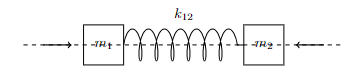

So, matrix representations are
$$
    \mathbf{M} = \begin{pmatrix}
            1 & 0\\
            0 & 1
            \end{pmatrix}
            \qquad (11)
            \
$$
$$
    \mathbf{F} = \begin{pmatrix}
            1 & -1\\
            -1 & 1
            \end{pmatrix}
            \qquad (12)
$$
and $\mathbf{A}$ is
\begin{align}
    \mathbf{A} &= \sqrt{\mathbf{M}}^{-1}\mathbf{F}\sqrt{\mathbf{M}}^{-1}
    \qquad  (13)\\
    &=  \begin{pmatrix}
            1 & 0\\
            0 & 1
            \end{pmatrix} \begin{pmatrix}
            1 & -1\\
            -1 & 1
            \end{pmatrix} \begin{pmatrix}
            1 & 0\\
            0 & 1
            \end{pmatrix} \\
    \mathbf{A} &= \begin{pmatrix}
            1 & -1\\
            -1 & 1
            \end{pmatrix} = \mathbf{F}  \qquad (14)
\end{align}


In order to create $\mathbf{B}$, use (10).

For $k=j=1$:
$$
\sqrt{\mathbf{M}}\mathbf{B}|{1,1}\rangle = \sqrt{\kappa_{11}}|{1}\rangle

$$

$$
\mathbf{B}|{1,1}\rangle = \begin{pmatrix}
    0 \\
    0
\end{pmatrix} 
$$

$$
\mathbf{B}\begin{pmatrix}
    1 \\
    0 \\
    0
\end{pmatrix} = \begin{pmatrix}
    0 \\
    0
\end{pmatrix} \qquad (15)
$$

For $k=1$ and $j=2$:
$$
\sqrt{\mathbf{M}}\mathbf{B}|{1,2}\rangle = \sqrt{\kappa_{12}}\left( |{1}\rangle - |{2} \rangle \right) 
$$

$$
\mathbf{B}|{1,2}\rangle = \left( |{1}\rangle - |{2} \rangle \right) 
$$

$$
\mathbf{B} \begin{pmatrix}
    0 \\
    1 \\
    0
\end{pmatrix} = \begin{pmatrix}
    1 \\
    0
\end{pmatrix} - \begin{pmatrix}
    0 \\
    1
\end{pmatrix} 
$$

$$
\mathbf{B} \begin{pmatrix}
    0 \\
    1 \\
    0
\end{pmatrix} = \begin{pmatrix}
    1 \\
    -1
\end{pmatrix} \qquad (16)
$$

For $k=j=2$:
$$
\sqrt{\mathbf{M}}\mathbf{B}|{2,2}\rangle = \sqrt{\kappa_{22}}|{2} \rangle 
$$

$$
\mathbf{B}|{2,2}\rangle = \begin{pmatrix}
    0 \\
    0
\end{pmatrix} 
$$

$$
\mathbf{B} \begin{pmatrix}
    0 \\
    0 \\
    1
\end{pmatrix} = \begin{pmatrix}
    0 \\
    0
\end{pmatrix} \qquad (17)
$$
Combining $(15), (16), (17)$
$$
\mathbf{B}\begin{pmatrix}
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 0 & 1
\end{pmatrix} = \begin{pmatrix}
    0 & 1 & 0 \\
    0 & -1 & 0
\end{pmatrix} 
$$

$$
\mathbf{B} = \begin{pmatrix}
    0 & 1 & 0 \\
    0 & -1 & 0
\end{pmatrix} \qquad (18)
$$

Lastly, show that $\mathbf{B}\mathbf{B}^\dagger = \mathbf{A}$
$$
\begin{pmatrix}
    0 & 1 & 0 \\
    0 & -1 & 0
\end{pmatrix} \begin{pmatrix}
    0 & 0 \\
    1 & -1 \\
    0 & 0
\end{pmatrix} = \begin{pmatrix}
    1 & -1 \\
    -1 & 1
\end{pmatrix} \qquad (19)
$$
That ends the constitution of $\mathbf{B}$ for this example.

Following equation $(7)$ the Hamiltonian ($H$) for this case becomes
$$
\mathbf{H} = \begin{pmatrix}
    0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    1 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{pmatrix} \qquad (20)
$$

___

We use the following methodology (for the simplest case atleast) to obtain $B$ from $A$.

For the square matrix $A$ we have the eigen value decomposition as follows: 

$$
A = V \Lambda V^T
$$

where:
    \item $V$ is the matrix of eigenvectors of $A$.
    \item $\Lambda$ is the diagonal matrix of eigenvalues of $A$.


Next, we construct the diagonal matrix $\sqrt{\Lambda}$ containing the square roots of the eigenvalues:

$$
\sqrt{\Lambda} = \text{diag}(\sqrt{\lambda_1}, \sqrt{\lambda_2}, \ldots, \sqrt{\lambda_n})
$$

We then define the matrix $B$ as follows:

$$B = V \sqrt{\Lambda}$$


Its easy to verify that $A$ can be reconstructed from $B$ as $ A= BB^T$

___


### Simulating the simplest Possible case:

In [50]:
from typing import cast
from classiq import *
from classiq.execution import ExecutionPreferences
import numpy as np
import matplotlib.pyplot as plt
from classiq.execution import ClassiqBackendPreferences
# from qiskit.quantum_info import SparsePauliOp


#### Pre-Processing before quantum evolution:

In [141]:
### Providing all inputs for 2 coupled SHO case and performing all the initial transformations

N=2
m= int(N*N)  # this is the value of M required for constructing B and y 

#masses
M_1= 1
M_2= 1

#spring constants
k_11=0
k_22=0
k_12=1

#initial conditions
initial_positions = np.array([[1], [0]])
initial_velocities= np.array([[1],[0]])

# Force matrix

F= np.array([[k_11+k_12, -k_12], [-k_12, k_12+k_22]])

# Mass matrix

M= np.array([[M_1, 0], [0, M_2]])
rootM= np.sqrt(M)
rootM_inverse= np.linalg.inv(rootM) # inverse of the square root M matrix

# Computing the matrix A
A = np.linalg.multi_dot([rootM_inverse, F, rootM_inverse])
#print(A)

# Transform coordinates

y_initial= np.matmul(rootM, initial_positions)
ydot_initial= np.matmul(rootM, initial_velocities)

# Perform eigen value decomposition to get the matrix B

# Eigenvalue decomposition of matrix A (A= V Λ V^{T})
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Construct the diagonal matrix of square roots of eigenvalues (square root of lambda matrix)
Lambda_sqrt = np.diag(np.sqrt(eigenvalues))

# Compute B
B = np.dot(eigenvectors, Lambda_sqrt)  # we define B this way, to ensure A = BB^T

# Verify A = BB^T
A_reconstructed = np.dot(B, B.T)

if np.array_equal(A_reconstructed, A):
    print("Decomposition works")
else:
    print("A is not BB^T")


# Stacking L with zeroes to get B to be of the order of N*((N(N+1)/2))
padded_B = np.zeros((m, m))
padded_B[:2, :2] = B

H = -np.block([[np.zeros((padded_B.shape[0], padded_B.shape[0])), padded_B], [padded_B.conj().T, np.zeros((padded_B.shape[1], padded_B.shape[1]))]])

print('Padded B matrix:', padded_B)
print('Hamiltonian formed:', H)

# B transpose matrix, useful for initial state amplitudes and padding the initial y vector (for multiplying it with B dagger)

padded_y_vector = np.pad(y_initial, ((0, m-N), (0, 0)), mode='constant', constant_values=0)
B_transpose= np.transpose(padded_B)


t_y= np.matmul(B_transpose, padded_y_vector)
lower_init_amp= complex(0,1) * np.matmul(B_transpose, padded_y_vector)
padded_ydotvector = np.pad(ydot_initial, ((0, m-N), (0, 0)), mode='constant', constant_values=0)


# Initial state for distribution (eq 15in the paper)
init_state = np.vstack((padded_ydotvector, lower_init_amp.reshape(-1, 1)))


print("The padded initial state:", init_state)

complex_index_start=  len(init_state) - len(padded_ydotvector)
print("The complex entries start from index:", complex_index_start)   #to track the index from where the entries of the state in equation 9 are complex


# def processed_initstae(init_state):

#     # Store the real part or the imaginary coefficient
#     real_or_imag_coeff = np.zeros(init_state.shape, dtype=init_state.real.dtype)

#     # Iterating through the array to extract the appropriate parts (for real_or_imag_coeff)
#     for i, val in enumerate(init_state):
#         if np.isreal(val):
#             real_or_imag_coeff[i] = val.real
#         else:
#             real_or_imag_coeff[i] = val.imag

#     # Geting the indices of purely imaginary elements (this is the place where we add a global phase 'i' to the initial state)
#     purely_imag_indices = np.where(np.iscomplex(init_state) & (init_state.real == 0))[0]

#     return real_or_imag_coeff, purely_imag_indices


# amplitudes_init, imag_indices = processed_initstae(init_state)
# print("Real part or imaginary coefficients:", amplitudes_init)
# print("Indices of purely imaginary numbers:", imag_indices)



Decomposition works
Padded B matrix: [[ 0. -1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
Hamiltonian formed: [[-0. -0. -0. -0. -0.  1. -0. -0.]
 [-0. -0. -0. -0. -0. -1. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0.]
 [ 1. -1. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0.]]
The padded initial state: [[ 1.+0.j]
 [ 0.+0.j]
 [ 0.+0.j]
 [ 0.+0.j]
 [ 0.+0.j]
 [-0.-1.j]
 [ 0.+0.j]
 [ 0.+0.j]]
The complex entries start from index: 4


#### Finding the Pauli decomposition of the Hamiltonian formed above:

In [142]:
from itertools import product

from numpy import kron

Paulidict = {
    "I": np.array([[1, 0], [0, 1]], dtype=np.complex128),
    "Z": np.array([[1, 0], [0, -1]], dtype=np.complex128),
    "X": np.array([[0, 1], [1, 0]], dtype=np.complex128),
    "Y": np.array([[0, -1j], [1j, 0]], dtype=np.complex128),
}


# generate all combinations of Pauli strings of size n
def generate_all_pauli_strings(seq, n):
    for s in product(seq, repeat=n):
        yield "".join(s)


# convert a Paulistring of size n to 2**n X 2**n matrix
def pauli_string_2mat(seq):
    myPmat = Paulidict[seq[0]]
    for p in seq[1:]:
        myPmat = kron(myPmat, Paulidict[p])
    return myPmat


# Hilbert-Schmidt-Product of two matrices M1, M2
def hilbert_schmidt(M1, M2):
    return (np.dot(M1.conjugate().transpose(), M2)).trace()

# Naive decomposition, running over all HS products for all Pauli strings
def lcu_naive(H):
    assert H.shape[0] == H.shape[1], "matrix is not square"
    assert H.shape[0] != 0, "matrix is of size 0"
    assert H.shape[0] & (H.shape[0] - 1) == 0, "matrix size is not 2**n"

    n = int(np.log2(H.shape[0]))
    myPualiList = list(generate_all_pauli_strings("IZXY", n))

    mylist = []

    for pstr in myPualiList:
        co = (1 / 2**n) * hilbert_schmidt(pauli_string_2mat(pstr), H)
        if co != 0:
            mylist = mylist + [(pstr, co)]

    return mylist


pauli_list= lcu_naive(H)
print("The Pauli decomposition of the Hamiltonian:", pauli_list)


The Pauli decomposition of the Hamiltonian: [('XII', (-0.25+0j)), ('XIZ', (0.25+0j)), ('XIX', (0.25+0j)), ('XZI', (-0.25+0j)), ('XZZ', (0.25+0j)), ('XZX', (0.25+0j)), ('YIY', (-0.25+0j)), ('YZY', (-0.25+0j))]


In [143]:
# check if the decomposition is correct and matches the Hamiltonian 

import qutip as qt
from qutip import qeye, sigmax, sigmay, sigmaz

test = -0.25 * qt.tensor(sigmax(), qeye(2), qeye(2)) \
    + 0.25 * qt.tensor(sigmax(), qeye(2), sigmaz()) \
    + 0.25 * qt.tensor(sigmax(), qeye(2), sigmax()) \
    - 0.25 * qt.tensor(sigmax(), sigmaz(), qeye(2)) \
    + 0.25 * qt.tensor(sigmax(), sigmaz(), sigmaz()) \
    + 0.25 * qt.tensor(sigmax(), sigmaz(), sigmax()) \
    - 0.25 * qt.tensor(sigmay(), qeye(2), sigmay()) \
    - 0.25 * qt.tensor(sigmay(), sigmaz(), sigmay())

test

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

Thus as we see, the decomposition is exact.

In [144]:
# converting the hamitonian formed above to a PauliTerm object, useful for simulation using classiq built-in functions

CHAR_TO_STUCT_DICT = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}

def pauli_str_to_enums(pauli):
    return [CHAR_TO_STUCT_DICT[s] for s in pauli]

def pauli_list_to_hamiltonian(pauli_list):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]

Paulis= pauli_list_to_hamiltonian(pauli_list)
Paulis


[PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.I: 0>, <Pauli.I: 0>], coefficient=-0.25),
 PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.I: 0>, <Pauli.Z: 3>], coefficient=0.25),
 PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.I: 0>, <Pauli.X: 1>], coefficient=0.25),
 PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.Z: 3>, <Pauli.I: 0>], coefficient=-0.25),
 PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.Z: 3>, <Pauli.Z: 3>], coefficient=0.25),
 PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.Z: 3>, <Pauli.X: 1>], coefficient=0.25),
 PauliTerm(pauli=[<Pauli.Y: 2>, <Pauli.I: 0>, <Pauli.Y: 2>], coefficient=-0.25),
 PauliTerm(pauli=[<Pauli.Y: 2>, <Pauli.Z: 3>, <Pauli.Y: 2>], coefficient=-0.25)]

### Hamiltonian simulation

We use the `exponentiation_with_depth_constraint` function of classiq that produces a quantum gate that approximates $e^{iHt}$, for any input **Hermitian operator** $H$ . The Classiq engine automatically generates an efficient higher-order Trotter-Suzuki quantum program that minimizes the functional error and satisfies a given local constraint on the depth. 

In [146]:
@qfunc
def p(x: QNum):
    a = QArray("a")
    b = QArray("b", QBit)
    allocate(3, b)
    bind(x, a)
    repeat(a.len, lambda i: CX(a[i], b[i]))
    control(b[2], lambda: PHASE(np.pi/2, a[2]))
    bind(a, x)


@qfunc
def main( state: Output[QNum] ):
    prepare_amplitudes(amplitudes=[np.sqrt(1/2),0,0,0, 0, np.sqrt(1/2),0, 0], out=state, bound=0.01)
    p(state)
    exponentiation_with_depth_constraint(
        pauli_list_to_hamiltonian(pauli_list),
        evolution_coefficient=10,
        max_depth=1000,
        qbv=state,
        )

qmod = create_model(main)
backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=4000, backend_preferences=backend_preferences))
qprog = synthesize(model_pref)
# show(qprog)

In [148]:
job = execute(qprog)
results = job.result()[0].value.parsed_counts
results

[{'state': 0.0}: 1507,
 {'state': 1.0}: 1505,
 {'state': 5.0}: 965,
 {'state': 4.0}: 23]

In [149]:
job.result()[0].value.parsed_state_vector  # to get the phases

[SimulatedState(state={'state': 0.0}, bitstring='101000', amplitude=(0.5114846222131033-2.235711615838909e-14j)),
 SimulatedState(state={'state': 1.0}, bitstring='101001', amplitude=(-0.48485831225661513+2.3098710444369175e-14j)),
 SimulatedState(state={'state': 5.0}, bitstring='000101', amplitude=(-2.220446049250313e-14-0.48485831225661435j)),
 SimulatedState(state={'state': 1.0}, bitstring='000001', amplitude=(0.3651965944611225-8.104628079763643e-15j)),
 SimulatedState(state={'state': 0.0}, bitstring='000000', amplitude=(0.35978644657484327-5.793976409762536e-15j)),
 SimulatedState(state={'state': 4.0}, bitstring='101100', amplitude=(2.220446049250313e-15+0.0567013748840437j)),
 SimulatedState(state={'state': 4.0}, bitstring='000100', amplitude=(-1.27675647831893e-15-0.045799315395654336j)),
 SimulatedState(state={'state': 5.0}, bitstring='101101', amplitude=(-2.498001805406602e-16+0.008991794117074386j)),
 SimulatedState(state={'state': 2.0}, bitstring='010010', amplitude=(-4.01283

In [161]:
# to add all amplitudes corresponding to a state and store it in a dictionary 

def sum_amplitudes_by_state(simulated_states):
    state_amplitude_sums = {state: 0 for state in range(8)}
    
    for sim_state in simulated_states:
        state_value = sim_state.state['state']
        if state_value in state_amplitude_sums:
            state_amplitude_sums[state_value] += sim_state.amplitude
    
    return state_amplitude_sums

d= sum_amplitudes_by_state(job.result()[0].value.parsed_state_vector)

d

{0: (0.8712710687879466-2.816785553937762e-14j),
 1: (-0.11966171779549263+1.4971136619764104e-14j),
 2: (-5.597517232248764e-16+6.951183241047692e-17j),
 3: (-2.6140444638718297e-16-3.716364608845779e-18j),
 4: (9.845866073990703e-16+0.010902059488389283j),
 5: (-2.2428402105425106e-14-0.47586651813953995j),
 6: (1.0968418635188516e-17-4.3253542249193997e-16j),
 7: (-2.5653201879259625e-17-1.6357374743534533e-16j)}

In [166]:
#Normalizing the final state and taking care of any global phases

values = np.array([d[i] for i in range(len(d))])
global_phase = np.angle(values)[0]
values = values / np.exp(1j * global_phase)
values

normalization = np.linalg.norm(
        [
            parsed_state.amplitude
            for parsed_state in parsed_state_vector
        ]
    )


Final_state = values / normalization

Final_state

array([ 8.71271069e-01+0.00000000e+00j, -1.19661718e-01+1.11025197e-14j,
       -5.59751723e-16+6.95118324e-17j, -2.61404446e-16-3.71636461e-18j,
        6.32127255e-16+1.09020595e-02j, -7.04382224e-15-4.75866518e-01j,
        1.09684186e-17-4.32535422e-16j, -2.56532019e-17-1.63573747e-16j])

#### Hamiltonian Simulation using block-encoding:

We have our hamiltonian of the form 
$$
H = \sum^{L-1}_{i=0} \alpha_i U_i,
$$
where $U_i$ are Pauli strings. We use Linear Combination of Unitaries (LCU) to form the block-encoding of $H$

LCU refers to $(\bar{\alpha}, m, 0)$-block encoding of a matrix given as a sum of unitaries:
$$
U_{(\bar{\alpha},m,0)-H} =\begin{pmatrix}
H/\bar{\alpha} & * \\
* & *
\end{pmatrix}, \text{   for     } H = \sum^{L-1}_{i=0} \alpha_i U_i, \,\,\,\,\, \alpha_i\geq 0
$$
with $\bar{\alpha}\equiv\sum^{L-1}_{i=0}\alpha_i$ and $m= \lceil\log_2(L) \rceil$. 
___

#TODO add relevant details on LCU methodology from [LCU tutorial](https://github.com/Classiq/classiq-library/blob/main/tutorials/linear_combination_of_unitaries/linear_combination_of_unitaries.ipynb)

In [128]:
# getting the normalized coefficents representing probabilities for the prepare block of LCU

import numpy as np


def get_normalized_lcu_coef(lcu_coef):
    # Calculate the normalization factor as the sum of moduli of the complex numbers
    normalization_factor = sum(np.abs(c) for c in lcu_coef)
 
    # Calculate the prepare_prob list as specified
    prepare_prob = [(np.abs(c) / normalization_factor) for c in lcu_coef]
    
    # Print the prepare_prob list
    print("The prepared probabilities:", prepare_prob)
    
    # Calculate the size of the block encoding
    coef_size = int(np.ceil(np.log2(len(prepare_prob))))
    
    # Pad prepare_prob with zeros to make its length a power of 2
    prepare_prob += [0] * (2**coef_size - len(prepare_prob))
    
    # Print the details
    print("The size of the block encoding:", coef_size)
    print("The normalized coefficients:", prepare_prob)
    print("The normalization factor:", normalization_factor)
    
    return normalization_factor, coef_size, prepare_prob

lcu_pauli_coef = [p.coefficient for p in Paulis]

normalization_ham, lcu_size_ham, prepare_probs_ham = get_normalized_lcu_coef(
    lcu_pauli_coef
)

lcu_size_ham


The prepared probabilities: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
The size of the block encoding: 3
The normalized coefficients: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
The normalization factor: 2.0


3

In [129]:
@qfunc
def apply_pauli_term(pauli_string: PauliTerm, x: QArray[QBit]):
    repeat(
        count=x.len,
        iteration=lambda index: switch(
            pauli_string.pauli[index],
            [
                lambda: IDENTITY(x[pauli_string.pauli.len - index - 1]),
                lambda: X(x[pauli_string.pauli.len - index - 1]),
                lambda: Y(x[pauli_string.pauli.len - index - 1]),
                lambda: Z(x[pauli_string.pauli.len - index - 1]),
            ],
        ),
    )
    
@qfunc
def lcu_paulis(
    pauli_terms_list: CArray[PauliTerm],
    probs: CArray[CReal],
    block: QNum,
    data: QArray[QBit],
):
    within_apply(
        lambda: inplace_prepare_state(probs, 0.0, block),
        lambda: repeat(
            count=pauli_terms_list.len,
            iteration=lambda i: control(
                block == i, lambda: apply_pauli_term(pauli_terms_list[i], data)
            ),       
            ),
    )
      

In [130]:
@qfunc
def my_walk_operator(block: QArray[QBit], data: QArray[QBit]) -> None:
    lcu_paulis(Paulis, prepare_probs_ham, block, data)
    reflect_about_zero(block)
    RY(2 * np.pi, block[0])  # for the minus sign

from scipy.special import eval_chebyt, jv


def get_cheb_coef(epsilon, t):
    poly_degree = int(
        np.ceil(
            t
            + np.log(epsilon ** (-1)) / np.log(np.exp(1) + np.log(epsilon ** (-1)) / t)
        )
    )
    cos_coef = [jv(0, t)] + [
        2 * jv(2 * k, t) * (-1) ** k for k in range(1, poly_degree // 2 + 1)
    ]
    sin_coef = [
        -2 * jv(2 * k - 1, t) * (-1) ** k for k in range(1, poly_degree // 2 + 1)
    ]
    return cos_coef, sin_coef

EVOLUTION_TIME = 10
EPS = 0.1


normalized_time = normalization_ham * EVOLUTION_TIME

cos_coef, sin_coef = get_cheb_coef(EPS, normalized_time)
combined_sin_cos_coef = []

for k in range(len(cos_coef) - 1):
    combined_sin_cos_coef.append(cos_coef[k])
    combined_sin_cos_coef.append(sin_coef[k])
combined_sin_cos_coef.append(cos_coef[-1])
if len(sin_coef) == len(cos_coef):
    combined_sin_cos_coef.append(sin_coef[-1])


signs_cheb_coef = np.sign(combined_sin_cos_coef).tolist()
generalized_signs = [
    (1 - signs_cheb_coef[s]) + (s) % 2 for s in range(len(signs_cheb_coef))
]
positive_cheb_lcu_coef = np.abs(combined_sin_cos_coef)


normalization_exp, lcu_size_exp, prepare_probs_exp = get_normalized_lcu_coef(
    positive_cheb_lcu_coef
)

@qfunc
def lcu_cheb(
    coef: CArray[CReal],
    generalized_signs: CArray[CInt],
    walk_operator: QCallable[QNum, QArray],
    walk_block: QNum,
    walk_data: QArray,
    cheb_block: QNum,
):

    within_apply(
        lambda: inplace_prepare_state(coef, 0.0, cheb_block),
        lambda: repeat(
            generalized_signs.len,
            lambda k: control(
                cheb_block == k,
                lambda: (
                    U(0, 0, 0, np.pi / 2 * generalized_signs[k], walk_data[0]),
                    power(k, lambda: walk_operator(walk_block, walk_data)),
                ),
            ),
        ),
    )

# lcu_size_exp

# prepare_probs_exp

The prepared probabilities: [0.027479190671058543, 0.021991005575390094, 0.052759280784578075, 0.03254286173230571, 0.04299642226488636, 0.04974143063826026, 0.018125706945756232, 0.06061685480571399, 0.02430609141824357, 0.04117198167111915, 0.0613608749222508, 0.020188893251131657, 0.03915309234600598, 0.06717260406633883, 0.048171292940234506, 0.00026720604998948535, 0.04777048386525028, 0.07669998023438993, 0.08261948253321262, 0.0720150883253928, 0.05420918528503369, 0.036403282244674574, 0.022237707428782914]
The size of the block encoding: 5
The normalized coefficients: [0.027479190671058543, 0.021991005575390094, 0.052759280784578075, 0.03254286173230571, 0.04299642226488636, 0.04974143063826026, 0.018125706945756232, 0.06061685480571399, 0.02430609141824357, 0.04117198167111915, 0.0613608749222508, 0.020188893251131657, 0.03915309234600598, 0.06717260406633883, 0.048171292940234506, 0.00026720604998948535, 0.04777048386525028, 0.07669998023438993, 0.08261948253321262, 0.072015

[0.027479190671058543,
 0.021991005575390094,
 0.052759280784578075,
 0.03254286173230571,
 0.04299642226488636,
 0.04974143063826026,
 0.018125706945756232,
 0.06061685480571399,
 0.02430609141824357,
 0.04117198167111915,
 0.0613608749222508,
 0.020188893251131657,
 0.03915309234600598,
 0.06717260406633883,
 0.048171292940234506,
 0.00026720604998948535,
 0.04777048386525028,
 0.07669998023438993,
 0.08261948253321262,
 0.0720150883253928,
 0.05420918528503369,
 0.036403282244674574,
 0.022237707428782914,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [131]:
@qfunc
def p(x: QNum):
    a = QArray("a")
    b = QArray("b", QBit)
    allocate(3, b)
    bind(x, a)
    repeat(a.len, lambda i: CX(a[i], b[i]))
    control(b[2], lambda: PHASE(np.pi/2, a[2]))
    bind(a, x)


@qfunc
def main(ham_block: Output[QNum], state: Output[QNum], exp_block: Output[QNum]):
    prepare_amplitudes(amplitudes=[np.sqrt(1/2),0,0,0,0,np.sqrt(1/2),0,0], out=state, bound=0.01)
    p(state)
    allocate(lcu_size_exp, exp_block)
    allocate(lcu_size_ham, ham_block)
    lcu_cheb(
        prepare_probs_exp,
        generalized_signs,
        lambda x, y: my_walk_operator(x, y),
        ham_block,
        state,
        exp_block,
    )
    

preferences = Preferences(
   timeout_seconds= 600
)
model = create_model(main)
qmod = set_preferences(model, preferences)

qprog = synthesize(qmod)
# show(qprog)

ClassiqAPIError: An unknown error occurred.

Error identifier: E373B9B32-1ADC-4E75-ADC8-A06DC7D575D1.
If you need further assistance, please reach out on our Community Slack channel at: https://short.classiq.io/join-slack

In [12]:
show(qprog)

Opening: https://platform.classiq.io/circuit/74dbe59e-1a66-4bfd-8a30-1e619c6a130c?version=0.43.3


In [ ]:
results = execute(qprog).result()
results

In [ ]:
expected_state = (
    1 / normalization_exp * scipy.linalg.expm(1j * H * EVOLUTION_TIME) @ init_state
)

In [ ]:
##Post Processing


def get_projected_state_vector(
    execution_result,
    measured_var: str,
    projections: dict,
) -> np.ndarray:
    """
    This function returns a reduced statevector from execution results.
    measured var: the name of the reduced variable
    projections: on which values of the other variables to project, e.g., {"ind": 1}
    """
    projected_size = len(execution_result[0].value.output_qubits_map[measured_var])
    proj_statevector = np.zeros(2**projected_size).astype(complex)
    for sample in execution_result[0].value.parsed_state_vector:
        if all(sample.state[key] == projections[key] for key in projections.keys()):
            proj_statevector[int(sample.state[measured_var])] += sample.amplitude
    return proj_statevector



results = execute(qprog).result()
state_result = get_projected_state_vector(
    results, "state", {"exp_block": 0.0, "ham_block": 0.0}
)

# expected state after evolution
expected_state = (
    1 / normalization_exp * scipy.linalg.expm(1j * H * EVOLUTION_TIME) @ init_state
)
relative_phase = np.angle(expected_state[0] / state_result[0])
state_result = state_result * np.exp(
    1j * relative_phase
)  # rotate according to a global phase

print("expected state:", expected_state)
print("resulting state:", state_result)
assert np.linalg.norm(state_result - expected_state) < EPS

In [ ]:
import pyqsp
from pyqsp.angle_sequence import Polynomial, QuantumSignalProcessingPhases

pg_cos = pyqsp.poly.PolyCosineTX()
pcoefs_cos, scale_cos = pg_cos.generate(
    epsilon=EPS, tau=normalized_time, return_scale=True
)
poly_cos = Polynomial(pcoefs_cos)

pg_sin = pyqsp.poly.PolySineTX()
pcoefs_sin, scale_sin = pg_sin.generate(
    epsilon=EPS, tau=normalized_time, return_scale=True
)
poly_sin = Polynomial(pcoefs_sin)

In [ ]:
ang_seq_cos = QuantumSignalProcessingPhases(
    poly_cos,
    signal_operator="Wx",
    method="laurent",
    measurement="x",
    tolerance=0.00001,  # relaxing the tolerance to get convergence
)

ang_seq_sin = QuantumSignalProcessingPhases(
    poly_sin,
    signal_operator="Wx",
    method="laurent",
    measurement="x",
    tolerance=0.00001,  # relaxing the tolerance to get convergence
)


# change W(x) to R(x), as the phases are in the W(x) conventions see Eq.()
def convert_phases_to_Rx_convention(ang_seq):

    phases = np.array(ang_seq)
    phases[1:-1] = phases[1:-1] - np.pi / 2
    phases[0] = phases[0] - np.pi / 4
    phases[-1] = phases[-1] + (2 * (len(phases) - 1) - 1) * np.pi / 4

    # verify conventions. minus is due to exp(-i*phi*z) in qsvt in comparison to qsp
    phases = -2 * phases

    return phases.tolist()

phases_cos = convert_phases_to_Rx_convention(ang_seq_cos)
phases_sin = convert_phases_to_Rx_convention(ang_seq_sin)

In [ ]:
@qfunc
def identify_block(num_data_qubits: CInt, qvar: QArray[QBit], qbit: QBit):
    block_qubits = QNum("block_qubits", qvar.len - num_data_qubits, False, 0)
    data = QArray("data", length=num_data_qubits)

    bind(qvar, [block_qubits, data])
    qbit ^= block_qubits == 0
    bind([block_qubits, data], qvar)


# defining a qsvt for the specific example
@qfunc
def my_qsvt(phases: CArray[CReal], qsvt_aux: QBit, block_ham: QArray, data: QArray):
    combined_vars = QArray("combined_vars")
    bind([block_ham, data], combined_vars)

    qsvt(
        phase_seq=phases,
        proj_cnot_1=lambda qvar, qbit: identify_block(data.len, qvar, qbit),
        proj_cnot_2=lambda qvar, qbit: identify_block(data.len, qvar, qbit),
        u=lambda x: lcu_paulis(
            Paulis,
            prepare_probs_ham,
            x[0 : block_ham.len],
            x[block_ham.len : x.len],
        ),
        qvar=combined_vars,
        aux=qsvt_aux,
    )

    bind(combined_vars, [block_ham, data])

In [ ]:
@qfunc
def main(
    qsvt_aux: Output[QBit],
    block_ham: Output[QNum],
    state: Output[QNum],
    block_exp: Output[QBit],
):
    allocate(1, qsvt_aux)
    allocate(1, block_exp)
    allocate(lcu_size_ham, block_ham)
    prepare_amplitudes(b, 0.0, state)
    within_apply(
        lambda: H(block_exp),
        lambda: (
            control(
                block_exp == 0,  # cosine
                lambda: my_qsvt(phases_cos, qsvt_aux, block_ham, state),
            ),
            control(
                block_exp == 1,  # sine
                lambda: (
                    U(0, 0, 0, pi / 2, qsvt_aux),  # for the i factor
                    my_qsvt(phases_sin, qsvt_aux, block_ham, state),
                ),
            ),
        ),
    )

### Classical solution using normal modes

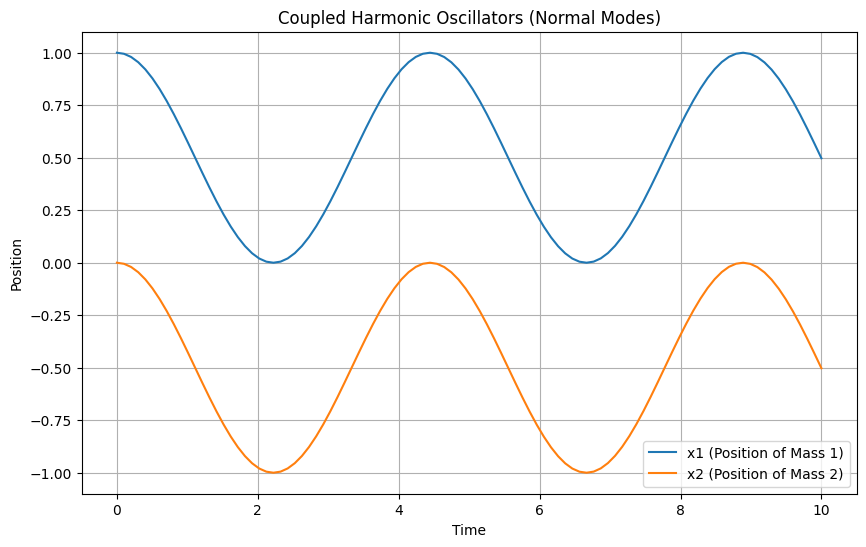

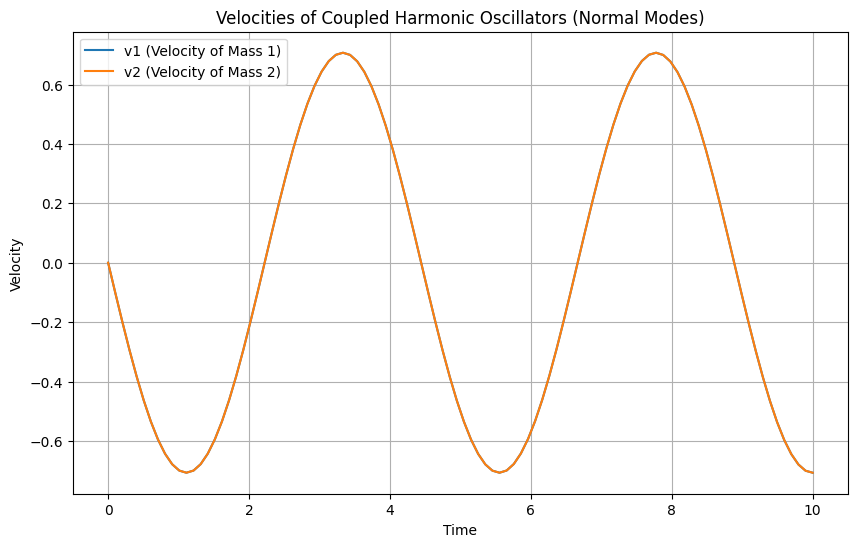

Final position of oscillator 1: 0.4975156689337027
Final position of oscillator 2: -0.502484331066297
Final velocity of oscillator 1: -0.707098052746793
Final velocity of oscillator 2: -0.7070980527467927


In [117]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
m1 =1.0  # Mass of first oscillator
m2 = 1.0  # Mass of second oscillator
k1 = 0.0  # Spring constant for first oscillator
k2 = 0.0  # Spring constant for second oscillator
k12 = 1.0  # Coupling spring constant

# Calculate the coefficients of the quadratic equation for omega^2 (obtained from eigenvalue equation)

a = m1 * m2
b = -(m1 * (k2 + k12) + m2 * (k1 + k12))
c = (k1 + k12) * (k2 + k12) - k12 ** 2

# Solve for omega^2 (eigenvalues)
omega_squared = np.roots([a, b, c])
omega1 = np.sqrt(omega_squared[0])
omega2 = np.sqrt(omega_squared[1])

# Calculate the mode shapes (eigenvectors)
A1 = np.array([k1 + k12 - m1 * omega1 ** 2, -k12])
A2 = np.array([k1 + k12 - m1 * omega2 ** 2, -k12])
A1 = A1 / np.linalg.norm(A1)
A2 = A2 / np.linalg.norm(A2)

# Initial conditions
x1_0 = 1.0  # Initial position of first oscillator
v1_0 = 1.0  # Initial velocity of first oscillator
x2_0 = 0.0  # Initial position of second oscillator
v2_0 = 0.0  # Initial velocity of second oscillator

# Initial conditions in terms of normal modes
C = np.linalg.inv(np.array([A1, A2]).T).dot([x1_0, x2_0])
phi1 = 0  # Assume phase angles are zero for simplicity
phi2 = 0

# Time span
t = np.linspace(0, 10, 100)

# Calculate the positions using the normal mode solution
x1 = C[0] * np.cos(omega1 * t + phi1) * A1[0] + C[1] * np.cos(omega2 * t + phi2) * A2[0]
x2 = C[0] * np.cos(omega1 * t + phi1) * A1[1] + C[1] * np.cos(omega2 * t + phi2) * A2[1]

# Calculate the velocities using the normal mode solution
v1 = -C[0] * omega1 * np.sin(omega1 * t + phi1) * A1[0] - C[1] * omega2 * np.sin(omega2 * t + phi2) * A2[0]
v2 = -C[0] * omega1 * np.sin(omega1 * t + phi1) * A1[1] - C[1] * omega2 * np.sin(omega2 * t + phi2) * A2[1]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, x1, label='x1 (Position of Mass 1)')
plt.plot(t, x2, label='x2 (Position of Mass 2)')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.title('Coupled Harmonic Oscillators (Normal Modes)')
plt.grid()
plt.show()

# Plot the velocity results
plt.figure(figsize=(10, 6))
plt.plot(t, v1, label='v1 (Velocity of Mass 1)')
plt.plot(t, v2, label='v2 (Velocity of Mass 2)')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()
plt.title('Velocities of Coupled Harmonic Oscillators (Normal Modes)')
plt.grid()
plt.show()

# print(t)
print("Final position of oscillator 1:", x1[-1])
print("Final position of oscillator 2:", x2[-1])


print("Final velocity of oscillator 1:", v1[-1])
print("Final velocity of oscillator 2:", v2[-1])
